<a href="https://colab.research.google.com/github/xatryx/python-tensorflow-collab-AegisML/blob/main/Bert_Architecture_Indo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning BERT Model Architecture

## Setup

### Installing Library/Packages

In [1]:
!pip install pip install transformers
!pip install kaggle
!pip install pandas

     |████████████████████████████████| 2.3MB 9.8MB/s 
     |████████████████████████████████| 901kB 35.8MB/s 
     |████████████████████████████████| 3.3MB 35.8MB/s 


In [2]:
import tensorflow as tf
print(tf.__version__)

2.5.0


### Connect Kaggle Api

In [3]:
from google.colab import files
 
uploaded = files.upload()
 
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


## Data Cleaning & Transform

### Download Data from Kaggle

In [4]:
!kaggle datasets download "ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text"

  0% 0.00/814k [00:00<?, ?B/s]
100% 814k/814k [00:00<00:00, 53.7MB/s]


In [5]:
ls

indonesian-abusive-and-hate-speech-twitter-text.zip  sample_data/


In [6]:
!unzip indonesian-abusive-and-hate-speech-twitter-text.zip

Archive:  indonesian-abusive-and-hate-speech-twitter-text.zip
  inflating: README.md               
  inflating: abusive.csv             
  inflating: citation.bib            
  inflating: data.csv                
  inflating: new_kamusalay.csv       


### Load dataframe 

In [7]:
import pandas as pd

tweet_df = pd.read_csv('data.csv', encoding='iso-8859-1')
tweet_df.head()

Tweet  ...  HS_Strong
0  - disaat semua cowok berusaha melacak perhatia...  ...          0
1  RT USER: USER siapa yang telat ngasih tau elu?...  ...          0
2  41. Kadang aku berfikir, kenapa aku tetap perc...  ...          0
3  USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...  ...          0
4  USER USER Kaum cebong kapir udah keliatan dong...  ...          0

[5 rows x 13 columns]

In [8]:
len(tweet_df)

13169

In [9]:
def extractFeatureDF(df):
  df = df.iloc[:,0:3]
  # df = df.rename(columns={"HS_Individual": "Bully", "HS_Race": "Racist"})
  return df


In [10]:
tweet_hs_abusive = extractFeatureDF(tweet_df)

In [11]:
tweet_hs_abusive.head()

Tweet  HS  Abusive
0  - disaat semua cowok berusaha melacak perhatia...   1        1
1  RT USER: USER siapa yang telat ngasih tau elu?...   0        1
2  41. Kadang aku berfikir, kenapa aku tetap perc...   0        0
3  USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...   0        0
4  USER USER Kaum cebong kapir udah keliatan dong...   1        1

### Data Cleaning

In [12]:
import re

In [13]:
# Remove RT and Tagging
tweet_hs_abusive["Tweet"] = tweet_hs_abusive["Tweet"].str.replace('(RT:?|USER:?)', '', regex=True)

In [14]:
# Remove TAB
tweet_hs_abusive["Tweet"] = tweet_hs_abusive["Tweet"].str.replace('\t', ' ', regex=True)

# Remove Double Space
tweet_hs_abusive["Tweet"] = tweet_hs_abusive["Tweet"].str.replace(' {2,}', ' ', regex=True)

# Remove \n
tweet_hs_abusive["Tweet"].replace(r'\s+|\\n', ' ', regex=True, inplace=True)

# Remove whitespace start & end of the line
tweet_hs_abusive["Tweet"] = tweet_hs_abusive["Tweet"].str.strip()

In [15]:
# Lower Case
tweet_hs_abusive["Tweet"] = tweet_hs_abusive["Tweet"].str.lower()

In [16]:
# Remove emoticon
tweet_hs_abusive["Tweet"].replace(r'\\x[0-9f]{,2}', '', regex=True, inplace=True)

In [17]:
# Remove special character start of sentences
tweet_hs_abusive["Tweet"] = tweet_hs_abusive["Tweet"].str.replace('^[-\.,;\[\]]', '', regex=True)

In [18]:
# Remove special character end of sentences
tweet_hs_abusive["Tweet"] = tweet_hs_abusive["Tweet"].str.replace('[`\'\.%]$', '', regex=True)

In [19]:
tweet_hs_abusive["Tweet"] = tweet_hs_abusive["Tweet"].apply(lambda elem: re.sub(r"\d+", "", elem))

In [20]:
tweet_hs_abusive["Tweet"].replace(r'\.{2,}', '', regex=True, inplace=True) # remove \n

In [21]:
tweet_hs_abusive["Tweet"].replace(r';+', '', regex=True, inplace=True) # remove \n

In [22]:
tweet_hs_abusive["Tweet"].replace(r'(ð\?+)+', '', regex=True, inplace=True) # remove \n

In [23]:
# remove hashtag
tweet_hs_abusive["Tweet"].replace(r'#(\w+)', '', regex=True, inplace=True) 

In [24]:
tweet_hs_abusive["Tweet"].replace(r'&amp', '', regex=True, inplace=True) # remove \n


In [25]:
tweet_hs_abusive["Tweet"].replace(r'(! )+', '!', regex=True, inplace=True) # remove \n


In [26]:
tweet_hs_abusive["Tweet"].replace(r'(:\)|:\'\)|:\(|\(":)', '', regex=True, inplace=True) # remove \n


In [27]:
tweet_hs_abusive["Tweet"].replace(r'[-:]', '', regex=True, inplace=True) # remove \n

In [28]:
tweet_hs_abusive["Tweet"].replace(r'[^a-zA-Z0-9 \n\.]', '', regex=True, inplace=True) # remove \n

In [29]:
tweet_hs_abusive.head(20)

Tweet  HS  Abusive
0    disaat semua cowok berusaha melacak perhatian...   1        1
1   siapa yang telat ngasih tau eluedan sarap gue ...   0        1
2   . kadang aku berfikir kenapa aku tetap percaya...   0        0
3   aku itu aku  ku tau matamu sipit tapi diliat d...   0        0
4   kaum cebong kapir udah keliatan dongoknya dari...   1        1
5                                 ya bani taplak dkk    1        1
6   deklarasi pilkada  aman dan anti hoax warga du...   0        0
7   gue baru aja kelar rewatch aldnoah zeropaling ...   0        1
8   nah admin belanja satu lagi port terbaik nak m...   0        0
9                             enak lg klo smbil ngewe   0        1
10  setidaknya gw punya jari tengah buat lu sebelo...   1        1
11  banci kaleng malu ga bisa jawab peanyaan kami ...   1        1
12  kalo belajar ekonomi mestinya jago memprivatis...   0        0
13  aktor huruhara  prabowo s ingin lengserkan pem...   1        0
14  bu guru enakan jadi jablay atau guru esde sih....   1        1
15  lawan bicara gw gak intelek kyk loe yg otak ga...   1        1
16         belakangan ini kok fikiran ampas banget ya   0        0
17                    ari sarua beki mah repeh monyet   0        1
18  jadi cowo itu harus gantle kalo ga gantle itu ...   1        1
19                                      slga mnr bom    0        0

### Display All Dataset

In [30]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', None)
    display(tweet_hs_abusive)

Tweet  \
0                                                                                                                                                                 disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego    
1                                                                                                                                                                                           siapa yang telat ngasih tau eluedan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga   
2                                          . kadang aku berfikir kenapa aku tetap percaya pada tuhan padahal aku selalu jatuh berkalikali. kadang aku merasa tuhan itu ninggalkan aku sendirian. ketika orangtuaku berencana berpisah ketika kakakku lebih memilih jadi kristen. ketika aku anak ter   
3                                                                                                                                                                                                                                     aku itu aku  ku tau matamu sipit tapi diliat dari mana itu aku   
4                                                                                                                                                                                                                     kaum cebong kapir udah keliatan dongoknya dari awal tambah dongok lagi hahahah   
5                                                                                                                                                                                                                                                                                ya bani taplak dkk    
6                                                                                                                                                                                                                                       deklarasi pilkada  aman dan anti hoax warga dukuh sari jabon   
7                                                                                                                                                                            gue baru aja kelar rewatch aldnoah zeropaling kampret emang endingnya karakter utama cowonya kena friendzone brayxd url   
8                                                                                  nah admin belanja satu lagi port terbaik nak makan ais kepal milo ais kepal horlicks atau cendol toping kaw kaw.   doket mano tu  gerai rojak mertuaku  taipan  depan twins baby  romantika  bank islam senawang    
9                                                                                                                                                                                                                                                                            enak lg klo smbil ngewe   
10                                                                                                                                                                                                                      setidaknya gw punya jari tengah buat lu sebelom gw ukur nyali sama bacot lu    
11                                                                                                                                                                                                                    banci kaleng malu ga bisa jawab peanyaan kami dari  hari lalu nyungsep koe url   
12                                                                                                                                                                                                                           kalo belajar ekonomi mestinya jago memprivatisasi hati orang. duh ironi   
13                                                                                                                                             

### Analyze Data

In [31]:
import matplotlib.pyplot as plt
import numpy as np

tweet_hs_abusive["Abusive"].unique()

array([1, 0])

In [32]:
tweet_hs_abusive["Neutral"] = np.where((tweet_hs_abusive["Abusive"] | tweet_hs_abusive["HS"]) == 0, 1, 0)

In [33]:
tweet_hs_abusive.head()

Tweet  ...  Neutral
0                                                                                                                         disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego   ...        0
1                                                                                                                                                   siapa yang telat ngasih tau eluedan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga  ...        0
2  . kadang aku berfikir kenapa aku tetap percaya pada tuhan padahal aku selalu jatuh berkalikali. kadang aku merasa tuhan itu ninggalkan aku sendirian. ketika orangtuaku berencana berpisah ketika kakakku lebih memilih jadi kristen. ketika aku anak ter  ...        1
3                                                                                                                                                                                             aku itu aku  ku tau matamu sipit tapi diliat dari mana itu aku  ...        1
4                                                                                                                                                                             kaum cebong kapir udah keliatan dongoknya dari awal tambah dongok lagi hahahah  ...        0

[5 rows x 4 columns]

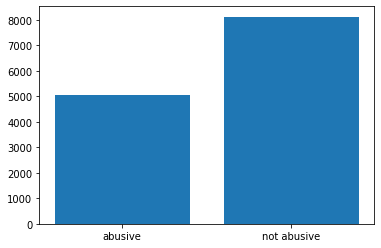

In [34]:
category_abusive = tweet_hs_abusive["Abusive"].unique()
counts_abusive = []

for i in category_abusive:
    count = len(tweet_hs_abusive[tweet_hs_abusive["Abusive"]==i])
    counts_abusive.append(count)

plt.bar(['abusive', 'not abusive'], counts_abusive)
plt.show()

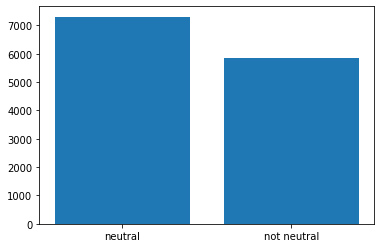

In [35]:
category_neutral = tweet_hs_abusive["Neutral"].unique()
counts_neutral = []

for i in category_neutral:
    count = len(tweet_hs_abusive[tweet_hs_abusive["Neutral"]==i])
    counts_neutral.append(count)

plt.bar(['neutral', 'not neutral'], counts_neutral)
plt.show()

## Prepare pre trained model & tokenizer


In [36]:
from transformers import AutoTokenizer, TFAutoModel
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
bert_classifier = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p1")

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Display Pre trained token **Token**

In [38]:
with open("vocabulary.txt", 'w') as f:
    
    # For each token...
    for token in tokenizer.vocab.keys():
        
        # Write it out and escape any unicode characters.            
        f.write(token + '\n')


In [39]:
token_val = {'Words': tokenizer.vocab.keys(), 'Token': tokenizer.vocab.values()}
token_data = pd.DataFrame(data=token_val, index=token_val['Token'])

In [40]:
token_data = token_data.sort_index()

In [41]:
token_data.head(20)

Words  Token
0    [PAD]      0
1    [UNK]      1
2    [CLS]      2
3    [SEP]      3
4   [MASK]      4
5     ##an      5
6        d      6
7     ##er      7
8        m      8
9     ##en      9
10       s     10
11       p     11
12    ##ar     12
13       b     13
14       k     14
15    ##at     15
16   ##ang     16
17    ##in     17
18       t     18
19    ##ak     19

## Pre trained 

### Labeling


Before we trained the model we need to define labeling for output of the sentiment 




In [42]:
import numpy as np

# abusive_sentiment = tweet_hs_abusive["Abusive"].values

# labels = np.zeros((abusive_sentiment.size, abusive_sentiment.max()+1))

# labels[np.arange(abusive_sentiment.size), abusive_sentiment] = 1

In [43]:
labels = tweet_hs_abusive[['Neutral', 'Abusive', 'HS']].to_numpy()

In [44]:
labels.shape

(13169, 3)

In [45]:
labels

array([[0, 1, 1],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 1]])

In [46]:
sentences = tweet_hs_abusive["Tweet"].values

### Prepare Tokenize Input IDs, attentions Masking, Type IDs to TF format

In [47]:
MAX_LEN = 128

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = np.zeros((len(tweet_hs_abusive), MAX_LEN))
attention_masks = np.zeros((len(tweet_hs_abusive), MAX_LEN))

def tokenize(sentence):
    encoded_sent = tokenizer.encode_plus(
                        sentence, 
                        max_length=MAX_LEN,
                        truncation=True, padding='max_length',
                        add_special_tokens=True, return_attention_mask=True,
                        return_token_type_ids=False, return_tensors='tf'
                   )
    
    return encoded_sent['input_ids'], encoded_sent['attention_mask']

for i, sentence in enumerate(tweet_hs_abusive['Tweet']):
    input_ids[i, :], attention_masks[i, :] = tokenize(sentence)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Attention Masks:', attention_masks[0])

Original:   disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego 
Token IDs: [2.0000e+00 9.5460e+03 3.6600e+02 5.7130e+03 2.3900e+03 1.4011e+04
 2.5980e+03 2.5260e+03 3.0470e+04 1.2217e+04 6.1170e+03 2.0781e+04
 3.2000e+01 2.5980e+03 7.4100e+02 2.5260e+03 1.3380e+03 8.5700e+02
 4.3000e+01 2.0783e+04 3.0470e+04 1.1954e+04 2.0783e+04 5.7130e+03
 8.7200e+02 3.0370e+04 3.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+

In [48]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  128


In [49]:
import tensorflow as tf

Afer we tokenize the input we need to do some padding for some text

For example if the longest sentences have 145 token if the token lower than that we need to use padding for that

In [50]:
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))


Padding/truncating all sentences to 128 values...

Padding token: "[PAD]", ID: 0


### Transform, randomize, batch dataset

In [51]:
BATCH_SIZE = 32  # we will use batches of 32
DATA_SHUFFLE = 100000

# load arrays into tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks, labels))

# create a mapping function that we use to restructure our dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# using map method to apply map_func to dataset
dataset = dataset.map(map_func)

# view the input format
dataset.take(1)

# shuffle data and batch it
dataset = dataset.shuffle(DATA_SHUFFLE).batch(BATCH_SIZE)

We split the database so it become 80% for training and 20% for validation

In [52]:
# get the length of the batched dataset
DS_LEN = len([0 for batch in dataset])
SPLIT = 0.8  # 80-20 split

train = dataset.take(round(DS_LEN*SPLIT))  # get first 80% of batches
val = dataset.skip(round(DS_LEN*SPLIT))  # skip first 80% and keep final 20%

del dataset  # optionally, delete dataset to free up disk-space

## Training the Model

In [53]:
def build_classifier_model(num_classes, seq_len):
  input_word_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
  input_mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

  embeddings = bert_classifier.bert(input_ids=input_word_ids, attention_mask=input_mask)[0]

  net = tf.keras.layers.Dropout(0.1)(embeddings)
  net = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768))(net)
  classifier = tf.keras.layers.Dense(num_classes, activation='softmax', name='classifier')(net)

  return tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=classifier)

In [54]:
classifier_model = build_classifier_model(num_classes=3, seq_len=MAX_LEN)

classifier_model.layers[2].trainable = False

classifier_model.summary()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 124441344   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
_______________________________________________________

In [58]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0000001, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy() 
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

history = classifier_model.fit(train, validation_data=val, epochs=10)

Epoch 1/10
330/330 [==============================] - 120s 314ms/step - loss: 0.9505 - accuracy: 0.7513 - val_loss: 0.9221 - val_accuracy: 0.7673
Epoch 2/10
330/330 [==============================] - 100s 302ms/step - loss: 0.9422 - accuracy: 0.7462 - val_loss: 0.9371 - val_accuracy: 0.7723
Epoch 3/10
330/330 [==============================] - 100s 302ms/step - loss: 0.9568 - accuracy: 0.7491 - val_loss: 0.9087 - val_accuracy: 0.7700
Epoch 4/10
330/330 [==============================] - 100s 302ms/step - loss: 0.9558 - accuracy: 0.7537 - val_loss: 0.9221 - val_accuracy: 0.7673
Epoch 5/10
330/330 [==============================] - 100s 302ms/step - loss: 0.9654 - accuracy: 0.7487 - val_loss: 0.9340 - val_accuracy: 0.7589
Epoch 6/10
330/330 [==============================] - 100s 302ms/step - loss: 0.9617 - accuracy: 0.7470 - val_loss: 0.9474 - val_accuracy: 0.7547
Epoch 7/10
330/330 [==============================] - 100s 303ms/step - loss: 0.9592 - accuracy: 0.7480 - val_loss: 0.9592 -

In [59]:
loss, accuracy = classifier_model.evaluate(val)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

82/82 [==============================] - 16s 195ms/step - loss: 0.9420 - accuracy: 0.7489
Loss: 0.9419696927070618
Accuracy: 0.748945951461792


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


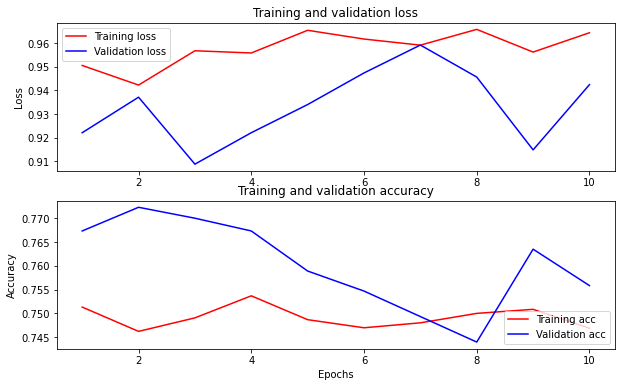

In [60]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Predictions

In [61]:
import numpy as np

In [62]:
def prep_data(text):
    tokens = tokenizer.encode_plus(
                        text, 
                        max_length=MAX_LEN,
                        truncation=True, padding='max_length',
                        add_special_tokens=True, return_attention_mask=True,
                        return_token_type_ids=False, return_tensors='tf'
                        )
    
    
    return {
        'input_ids': tf.cast(tokens['input_ids'], tf.float64),
        'attention_mask': tf.cast(tokens['attention_mask'], tf.float64),
    }

In [63]:
sentence_predict = prep_data("anjing kecil di rumah lucu")
results = classifier_model.predict(sentence_predict)

In [64]:
results

array([[0.91542494, 0.07659724, 0.00797789]], dtype=float32)

In [66]:
neutral = float(results[0][0]*100)
abusive = float(results[0][1]*100)
hate_speech = float(results[0][2]*100)

"Neutral: {}%, Abusive: {}%, Hate Speech: {}%".format(neutral, abusive, hate_speech)

'Neutral: 91.54249429702759%, Abusive: 7.659723609685898%, Hate Speech: 0.7977893576025963%'

## Save Model

In [67]:
classifier_model.save("abusive_model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: abusive_model/assets


INFO:tensorflow:Assets written to: abusive_model/assets


In [68]:
in_disk_model = tf.keras.models.load_model('abusive_model')

# view model architecture to confirm we have save and loaded correctly
in_disk_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 124441344   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 128, 768)     0           bert[0][0]                   

In [69]:
sentence_test = prep_data("keliatannya baik sih tapi kelakuannya songgong")

In [73]:
in_memory_pred = classifier_model.predict(sentence_test)
in_disk_pred = in_disk_model.predict(sentence_test)

def printModel(model):
  neutral = float(model[0][0]*100)
  abusive = float(model[0][1]*100)
  hate_speech = float(model[0][2]*100)
  return "Neutral: {}% Abusive: {}% Hate: {}%".format(neutral, abusive, hate_speech)

print(printModel(in_memory_pred))
print(printModel(in_disk_pred))

Neutral: 0.11630243388935924% Abusive: 63.10299634933472% Hate: 36.78070306777954%
Neutral: 0.11630243388935924% Abusive: 63.10299634933472% Hate: 36.78070306777954%


## Upload & Download -> Cloud Storage

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!curl https://sdk.cloud.google.com | bash

In [ ]:
!gcloud init

In [ ]:
!gsutil cp -r abusive_model gs://aegis_ml

In [ ]:
!rm -rf abusive_model

In [ ]:
!gsutil cp -r gs://aegis_ml abusive_model

Copying gs://aegis_ml/abusive_model/saved_model.pb...
Copying gs://aegis_ml/abusive_model/variables/variables.data-00000-of-00001...
Copying gs://aegis_ml/abusive_model/variables/variables.index...
| [3 files][592.0 MiB/592.0 MiB]                                                
Operation completed over 3 objects/592.0 MiB.                                    


In [ ]:
!ls

abusive.csv	  indonesian-abusive-and-hate-speech-twitter-text.zip
abusive_model.h5  new_kamusalay.csv
adc.json	  README.md
aegis_ml	  sample_data
citation.bib	  vocabulary.txt
data.csv
